In [1]:
# Step 1: Install Grad-CAM. Mount Google Drive. Move dataset to colab local
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

from google.colab import drive
drive.mount('/content/drive')

!gdown 19sIS06yTkiMFwn7sH1sk0KLggWgiV4Gl -O downloaded_file.zip
!unzip downloaded_file.zip -d /content/Pre-processing_data


Streaming output truncated to the last 5000 lines.
  inflating: /content/Pre-processing_data/Pre-processing data_actual/Normal_xrays/Normal (4396).png  
  inflating: /content/Pre-processing_data/Pre-processing data_actual/Normal_xrays/Normal (4397).png  
  inflating: /content/Pre-processing_data/Pre-processing data_actual/Normal_xrays/Normal (4398).png  
  inflating: /content/Pre-processing_data/Pre-processing data_actual/Normal_xrays/Normal (4399).png  
  inflating: /content/Pre-processing_data/Pre-processing data_actual/Normal_xrays/Normal (44).png  
  inflating: /content/Pre-processing_data/Pre-processing data_actual/Normal_xrays/Normal (440).png  
  inflating: /content/Pre-processing_data/Pre-processing data_actual/Normal_xrays/Normal (4400).png  
  inflating: /content/Pre-processing_data/Pre-processing data_actual/Normal_xrays/Normal (4401).png  
  inflating: /content/Pre-processing_data/Pre-processing data_actual/Normal_xrays/Normal (4402).png  
  inflating: /content/Pre-processi

In [2]:
# Step 2: Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision.models import resnet50
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Step 3: Verify and Activate the L4 GPU
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"Found GPU: {device_name}")

    # Step 2: Display detailed GPU information
    gpu_properties = torch.cuda.get_device_properties(0)
    print(f"GPU Name: {gpu_properties.name}")
    print(f"Total Memory: {gpu_properties.total_memory / (1024 ** 3):.2f} GB")
    print(f"Multiprocessors: {gpu_properties.multi_processor_count}")
else:
    print("No GPU found. Please make sure GPU runtime is enabled.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Test tensor on GPU
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print(f'Testing torch tensor... ', x)

Found GPU: NVIDIA L4
GPU Name: NVIDIA L4
Total Memory: 22.17 GB
Multiprocessors: 58
Using device: cuda
Testing torch tensor...  tensor([1., 2., 3.], device='cuda:0')


In [7]:
# Step 4: Paths for images and masks
covid_path = "/content/Pre-processing_data/Pre-processing data_actual/COVID19_xrays"
noncovid_path = "/content/Pre-processing_data/Pre-processing data_actual/NonCOVID19_xrays"
normal_path = "/content/Pre-processing_data/Pre-processing data_actual/Normal_xrays"

covid_mask_path = "/content/Pre-processing_data/Pre-processing data_actual/lung_masks_COVID19"
noncovid_mask_path = "/content/Pre-processing_data/Pre-processing data_actual/lung_masks_NonCOVID"
normal_mask_path = "/content/Pre-processing_data/Pre-processing data_actual/lung_masks_Normal"

In [53]:
# Step 5: Check the number of CPU cores and set the number of workers, batch & image size
import multiprocessing

num_cores = multiprocessing.cpu_count()
num_workers = int(num_cores * 0.60)
print(f"Number of CPU cores: {num_cores}")
print(f"Number of workers (60%): {num_workers}")
batch_size = 128
image_size = 256

Number of CPU cores: 12
Number of workers (60%): 7


In [54]:
# Step 6: Load image and mask file paths
def load_image_mask_paths(image_path, mask_path):
    image_files = os.listdir(image_path)
    image_paths = [os.path.join(image_path, img) for img in image_files]
    mask_paths = [os.path.join(mask_path, img) for img in image_files]
    return image_paths, mask_paths

# Load data paths
covid_image_paths, covid_mask_paths = load_image_mask_paths(covid_path, covid_mask_path)
noncovid_image_paths, noncovid_mask_paths = load_image_mask_paths(noncovid_path, noncovid_mask_path)
normal_image_paths, normal_mask_paths = load_image_mask_paths(normal_path, normal_mask_path)

# Create labels
covid_labels = np.zeros(len(covid_image_paths))
noncovid_labels = np.ones(len(noncovid_image_paths))
normal_labels = np.full(len(normal_image_paths), 2)

# Combine data
image_paths = covid_image_paths + noncovid_image_paths + normal_image_paths
mask_paths = covid_mask_paths + noncovid_mask_paths + normal_mask_paths
labels = np.concatenate((covid_labels, noncovid_labels, normal_labels), axis=0)

In [55]:
# Step 7: Split data into train, validation, and test sets
train_image_paths, test_image_paths, train_labels, test_labels, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, labels, mask_paths, test_size=0.3, random_state=42)
val_image_paths, test_image_paths, val_labels, test_labels, val_mask_paths, test_mask_paths = train_test_split(
    test_image_paths, test_labels, test_mask_paths, test_size=0.5, random_state=42)

In [56]:
# Step 8: Define custom Dataset class
class XRayDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask on-the-fly
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise ValueError(f"Error loading image or mask at index {idx}")

        image = cv2.resize(image, (image_size, image_size)) / 255.0
        mask = cv2.resize(mask, (image_size, image_size)) / 255.0

        # Apply mask to the image
        image = image * mask
        image = np.stack([image, image, image], axis=-1)  # Convert to 3 channels for ResNet50

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [58]:
# Step 9: Define transformations for data augmentation and normalization for training dataset
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(15),
    #transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ElasticTransform(alpha=15.0, sigma=3.0),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transformations for validation and test datasets (no augmentation, just normalization)
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [59]:
# Step 10: Create datasets and data loaders
train_dataset = XRayDataset(train_image_paths, train_mask_paths, train_labels, transform=train_transform)
val_dataset = XRayDataset(val_image_paths, val_mask_paths, val_labels, transform=val_test_transform)
test_dataset = XRayDataset(test_image_paths, test_mask_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, prefetch_factor=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, prefetch_factor=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, prefetch_factor=2, pin_memory=True)

In [60]:
# Step 11: Load pre-trained ResNet50 model
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),  # Increased dropout rate to reduce overfitting
    nn.BatchNorm1d(512),
    nn.Linear(512, 3)
)  # Modify the output layer for 3 classes with dropout and batch normalization
resnet50 = resnet50.to(device)

In [61]:
# Step 12: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0003, weight_decay=1e-4)  # Increased weight decay for stronger regularization
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=50)  # Use OneCycleLR for optimal learning rate
#reduce_lr_on_plateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)  # Reduce LR on plateau

In [62]:
# Step 13: Training loop without Mixed Precision

num_epochs = 50
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    # Initialize training accuracy counters for this epoch
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, dtype=torch.long, non_blocking=True)

        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(resnet50.parameters(), max_norm=1.0)  # Reduced max norm for more stable training

        # Optimizer step
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Compute average training loss and accuracy after all batches in this epoch
    train_loss_avg = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss_avg)
    train_accuracies.append(train_accuracy)

    # Validation
    resnet50.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, dtype=torch.long, non_blocking=True)
            outputs = resnet50(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_loss_avg = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_targets, val_preds)

    train_losses.append(train_loss_avg)
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {train_loss_avg:.4f}, Training Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping and checkpointing
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        early_stopping_counter = 0
        # Save the best model
        torch.save(resnet50.state_dict(), '/content/drive/MyDrive/Best_CNN_ResNet50_final_Torch_model.pth')

        # Save the checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': resnet50.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'best_val_loss': best_val_loss,
            'early_stopping_counter': early_stopping_counter
        }
        torch.save(checkpoint, '/content/drive/MyDrive/CNN_ResNet50_training_checkpoint.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

print("Training complete.")

# After the training loop ends
if early_stopping_counter < early_stopping_patience:
    torch.save(resnet50.state_dict(), '/content/drive/MyDrive/CNN_ResNet50_final_Torch_model.pth')
    print("Final model saved to /content/drive/MyDrive/CNN_ResNet50_final_Torch_model.pth")
else:
    print("Training stopped early. Best model already saved.")


Epoch [1/50], Loss: 0.7855, Training Accuracy: 0.6476, Validation Loss: 52.3795, Validation Accuracy: 0.3551
Epoch [2/50], Loss: 0.5273, Training Accuracy: 0.7865, Validation Loss: 30.0974, Validation Accuracy: 0.3341
Epoch [3/50], Loss: 0.4275, Training Accuracy: 0.8298, Validation Loss: 1.7833, Validation Accuracy: 0.4933
Epoch [4/50], Loss: 0.3891, Training Accuracy: 0.8475, Validation Loss: 0.5057, Validation Accuracy: 0.7905
Epoch [5/50], Loss: 0.3620, Training Accuracy: 0.8619, Validation Loss: 0.5011, Validation Accuracy: 0.7980
Epoch [6/50], Loss: 0.3542, Training Accuracy: 0.8617, Validation Loss: 0.4943, Validation Accuracy: 0.8180
Epoch [7/50], Loss: 0.3484, Training Accuracy: 0.8641, Validation Loss: 2.2339, Validation Accuracy: 0.6500
Epoch [8/50], Loss: 0.3537, Training Accuracy: 0.8628, Validation Loss: 0.6407, Validation Accuracy: 0.7219
Epoch [9/50], Loss: 0.3483, Training Accuracy: 0.8644, Validation Loss: 0.7664, Validation Accuracy: 0.7203
Epoch [10/50], Loss: 0.346

In [52]:
# import torch
# torch.cuda.empty_cache()
# # reset GPU RAM when interrupted the run

In [ ]:
# # Initialize the model architecture
# resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# resnet50.fc = nn.Sequential(
#     nn.Linear(resnet50.fc.in_features, 512),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.BatchNorm1d(512),
#     nn.Linear(512, 3)
# )
# resnet50 = resnet50.to(device)

# # Load the saved model state
# model_path = '/content/drive/MyDrive/CNN_ResNet50_final_Torch_model.pth'
# resnet50.load_state_dict(torch.load(model_path))
# resnet50.eval()
# print(f"Model loaded from {model_path} for inference.")


In [ ]:
# # Define the path to the checkpoint
# checkpoint_path = '/content/drive/MyDrive/CNN_ResNet50_training_checkpoint.pth'

# # Load the checkpoint
# checkpoint = torch.load(checkpoint_path)

# # Restore the model state
# resnet50.load_state_dict(checkpoint['model_state_dict'])
# resnet50 = resnet50.to(device)

# # Restore optimizer and scheduler states
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# # Restore other variables
# epoch = checkpoint['epoch']
# train_losses = checkpoint['train_losses']
# val_losses = checkpoint['val_losses']
# val_accuracies = checkpoint['val_accuracies']
# best_val_loss = checkpoint['best_val_loss']
# early_stopping_counter = checkpoint['early_stopping_counter']

# print(f"Training resumed from epoch {epoch}.")


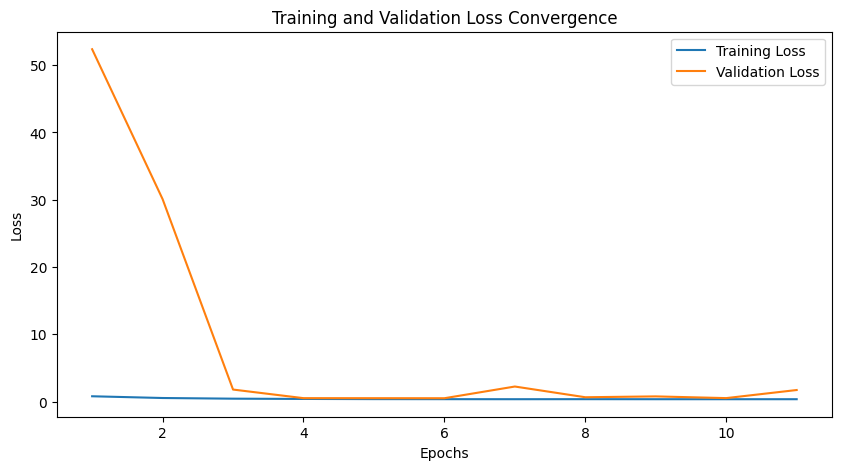

NameError: name 'train_accuracies' is not defined

<Figure size 1000x500 with 0 Axes>

In [64]:
# Step 14: Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Convergence')
plt.legend()
plt.show()

# Plot convergence of validation and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Convergence')
plt.legend()
plt.show()

<ipython-input-65-1823d8c260be>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50.load_state_dict(torch.load(best_model_path))


Test Accuracy: 0.8182
Classification Report:
              precision    recall  f1-score   support

       COVID       0.91      0.76      0.83      1770
   Non-COVID       0.80      0.79      0.80      1680
      Normal       0.77      0.90      0.83      1638

    accuracy                           0.82      5088
   macro avg       0.82      0.82      0.82      5088
weighted avg       0.83      0.82      0.82      5088



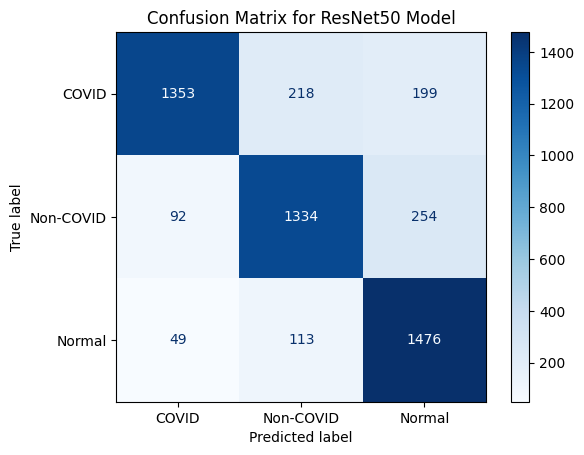

In [65]:
# Step 15: Classification report and Confusion Matrix
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load the best saved model
best_model_path = '/content/drive/MyDrive/Best_CNN_ResNet50_final_Torch_model.pth'
resnet50.load_state_dict(torch.load(best_model_path))
resnet50.to(device)  # Ensure the model is on the correct device
resnet50.eval()

test_preds = []
test_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, dtype=torch.long, non_blocking=True)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(test_targets, test_preds, target_names=['COVID', 'Non-COVID', 'Normal']))

# Generate confusion matrix
cm = confusion_matrix(test_targets, test_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID', 'Non-COVID', 'Normal'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for ResNet50 Model")
plt.show()


In [66]:
# Step 16: Save Model to Google Drive
model_save_path = '/content/drive/MyDrive/CNN_ResNet50_final_Torch_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

NameError: name 'model' is not defined

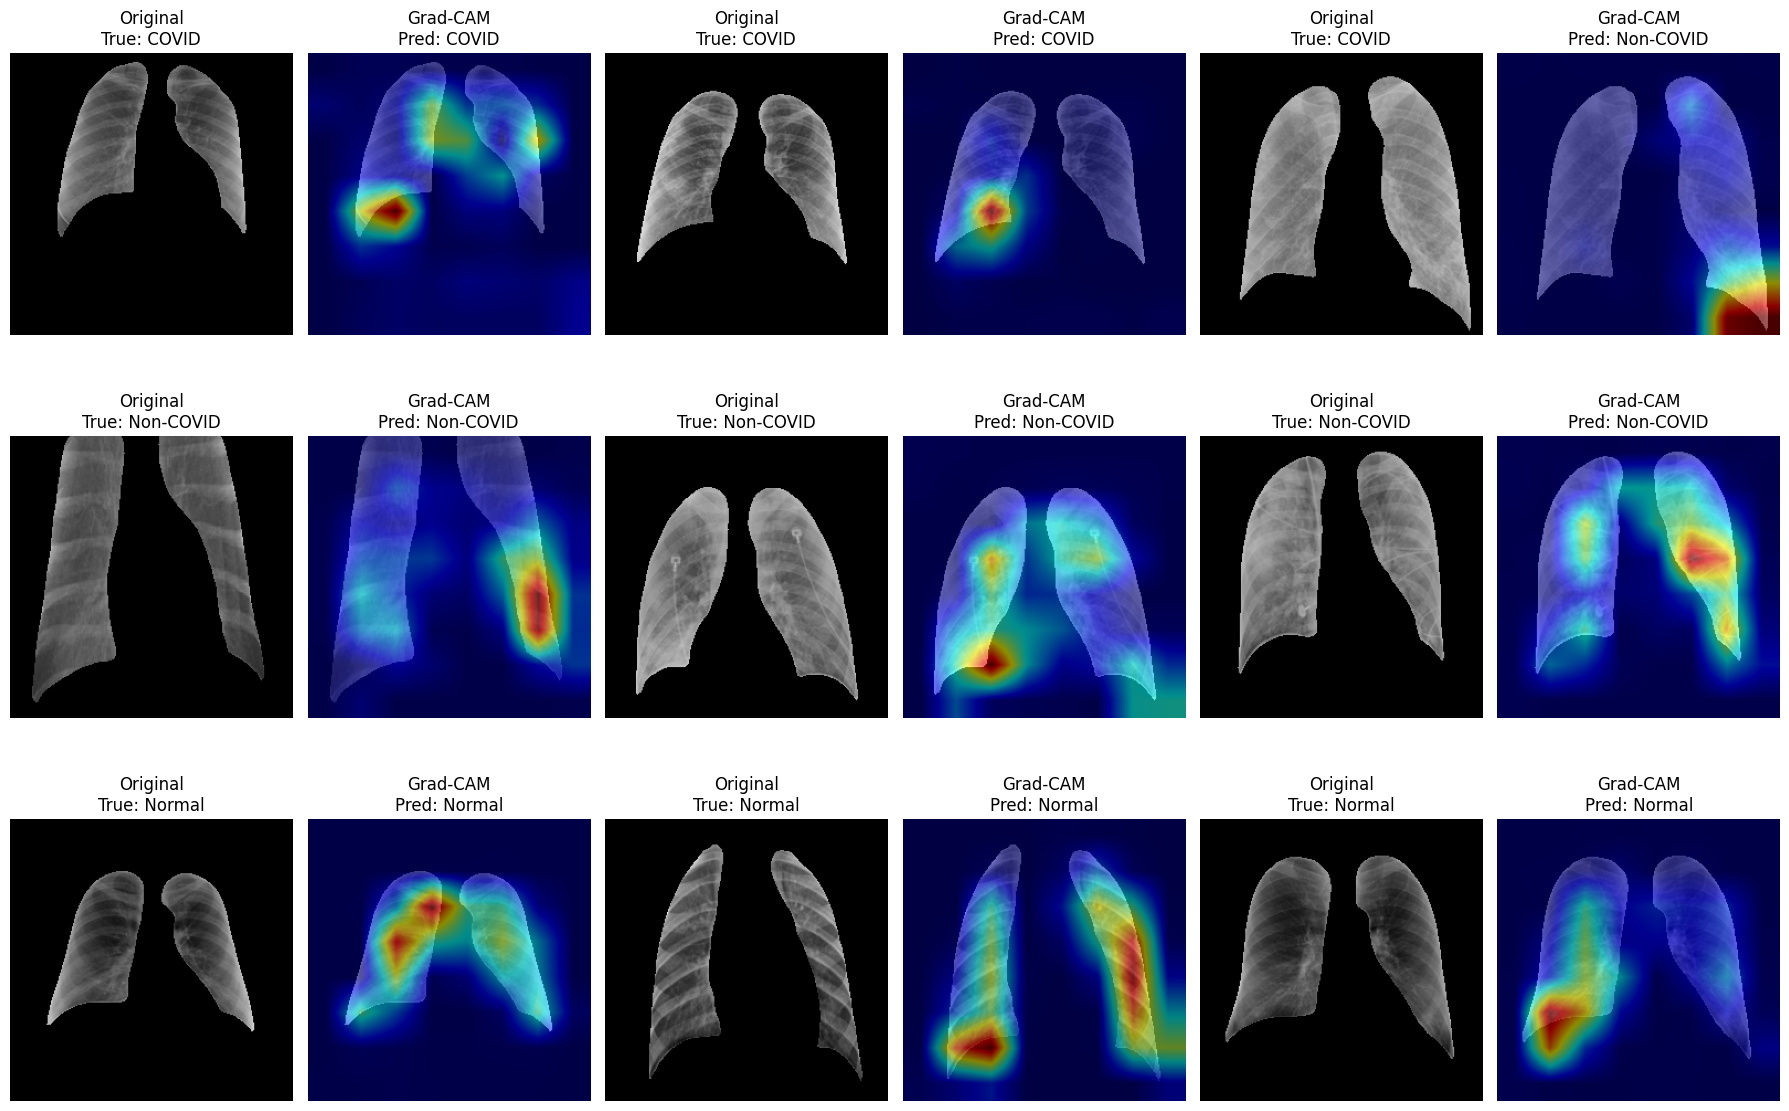

In [67]:
# Step 17: Grad-CAM Visualization
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Ensure evaluation mode
resnet50.eval()

# Define class names if not defined
class_names = ['COVID', 'Non-COVID', 'Normal']

# Extract indices from val_dataset by class
class_indices = {0: [], 1: [], 2: []}
for i, label in enumerate(val_dataset.labels):
    class_indices[label].append(i)

# Randomly select three indices from each class
selected_indices = []
for class_label in range(3):
    selected_indices.extend(random.sample(class_indices[class_label], 3))

# Set the target layer for Grad-CAM - the last convolutional block of ResNet50
target_layers = [resnet50.layer4[-1]]

# Initialize Grad-CAM
with GradCAM(model=resnet50, target_layers=target_layers) as cam:
    fig, axs = plt.subplots(3, 6, figsize=(18, 12))  # 3 rows, 6 columns (original + Grad-CAM for each sample)

    for i, idx in enumerate(selected_indices):
        image_tensor, label = val_dataset[idx]

        # The Grad-CAM requires a batch of images, so we add a batch dimension
        input_tensor = image_tensor.unsqueeze(0).to(device)

        # Forward to get predictions
        with torch.no_grad():
            outputs = resnet50(input_tensor)
            pred_class = torch.argmax(outputs, dim=1).item()

        # Compute the Grad-CAM
        targets = [ClassifierOutputTarget(pred_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension from CAM output

        # Denormalize the image
        mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)
        std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)
        denormalized_img = image_tensor.to(device) * std + mean
        denormalized_img = denormalized_img.permute(1, 2, 0).cpu().numpy()  # H x W x C
        denormalized_img = np.clip(denormalized_img, 0, 1)

        # Overlay CAM
        cam_image = show_cam_on_image(denormalized_img, grayscale_cam, use_rgb=True)

        # Plot the original image
        axs[i // 3, (i % 3) * 2].imshow(denormalized_img)
        axs[i // 3, (i % 3) * 2].axis('off')
        axs[i // 3, (i % 3) * 2].set_title(f"Original\nTrue: {class_names[int(label)]}", fontsize=12)

        # Plot the Grad-CAM image
        axs[i // 3, (i % 3) * 2 + 1].imshow(cam_image)
        axs[i // 3, (i % 3) * 2 + 1].axis('off')
        axs[i // 3, (i % 3) * 2 + 1].set_title(f"Grad-CAM\nPred: {class_names[pred_class]}", fontsize=12)

    plt.tight_layout()
    plt.show()
